In [24]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image # Pillow for image loading
import random

In [6]:
# Assuming the project root is the parent of the 'notebooks' directory
PROJECT_ROOT = Path(_dh[0]).parent

BASE_DATA_PATH = PROJECT_ROOT / "data" / "raw" / "chest_xray" # Adjust 'chest_xray' if needed
TRAIN_DIR = BASE_DATA_PATH / "train"
VAL_DIR = BASE_DATA_PATH / "val"
TEST_DIR = BASE_DATA_PATH / "test"

# Verify paths exist
print(f"Train dir exists: {TRAIN_DIR.exists()}")
print(f"Val dir exists: {VAL_DIR.exists()}")
print(f"Test dir exists: {TEST_DIR.exists()}")



Train dir exists: True
Val dir exists: True
Test dir exists: True


In [7]:
def load_filepaths_labels(data_dir, split_name):
    filepaths = []
    labels = []
    for label in ["NORMAL", "PNEUMONIA"]:
        class_dir = data_dir / label
        # Use rglob to find all jpeg files recursively (handles potential subdirs)
        for filepath in class_dir.rglob('*.jpeg'):
            filepaths.append(str(filepath)) # Store as string
            labels.append(label)
    df = pd.DataFrame({'filepath': filepaths, 'label': labels, 'split': split_name})
    return df

train_df = load_filepaths_labels(TRAIN_DIR, 'train')
val_df = load_filepaths_labels(VAL_DIR, 'val')
test_df = load_filepaths_labels(TEST_DIR, 'test')

# Combine into a single dataframe
all_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

print(f"Total images: {len(all_df)}")
print(all_df.head())

Total images: 5856
                                            filepath   label  split
0  /Users/hisham/pneumonia-detection-mlops/data/r...  NORMAL  train
1  /Users/hisham/pneumonia-detection-mlops/data/r...  NORMAL  train
2  /Users/hisham/pneumonia-detection-mlops/data/r...  NORMAL  train
3  /Users/hisham/pneumonia-detection-mlops/data/r...  NORMAL  train
4  /Users/hisham/pneumonia-detection-mlops/data/r...  NORMAL  train



Images per split:
split
train    5216
test      624
val        16
Name: count, dtype: int64

Label distribution per split:
label    NORMAL  PNEUMONIA
split                     
test   0.375000   0.625000
train  0.257094   0.742906
val    0.500000   0.500000


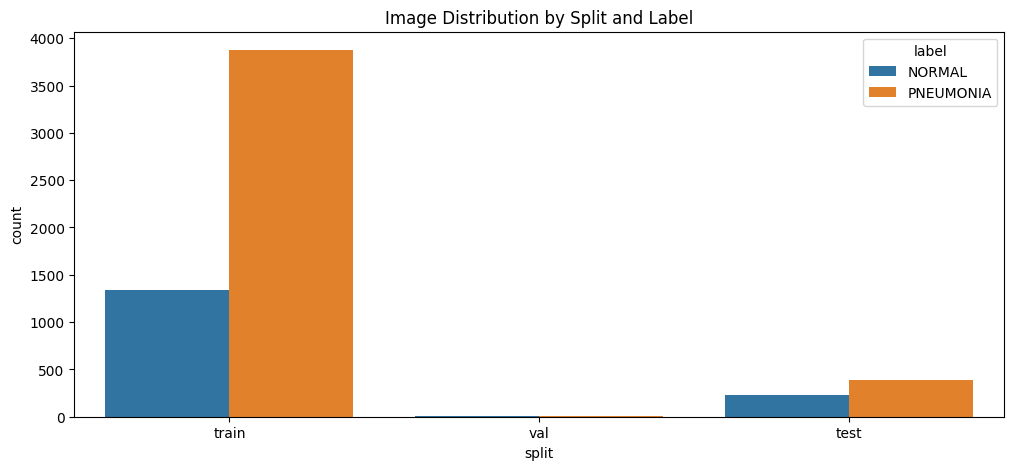

In [11]:
print("\nImages per split:")
print(all_df['split'].value_counts())

print("\nLabel distribution per split:")
print(all_df.groupby('split')['label'].value_counts(normalize=True).unstack())

# Visualize class distribution
plt.figure(figsize=(12, 5))
sns.countplot(data=all_df, x='split', hue='label')
plt.title('Image Distribution by Split and Label')
plt.show()

Visualize Sample Images 


Sample Images:


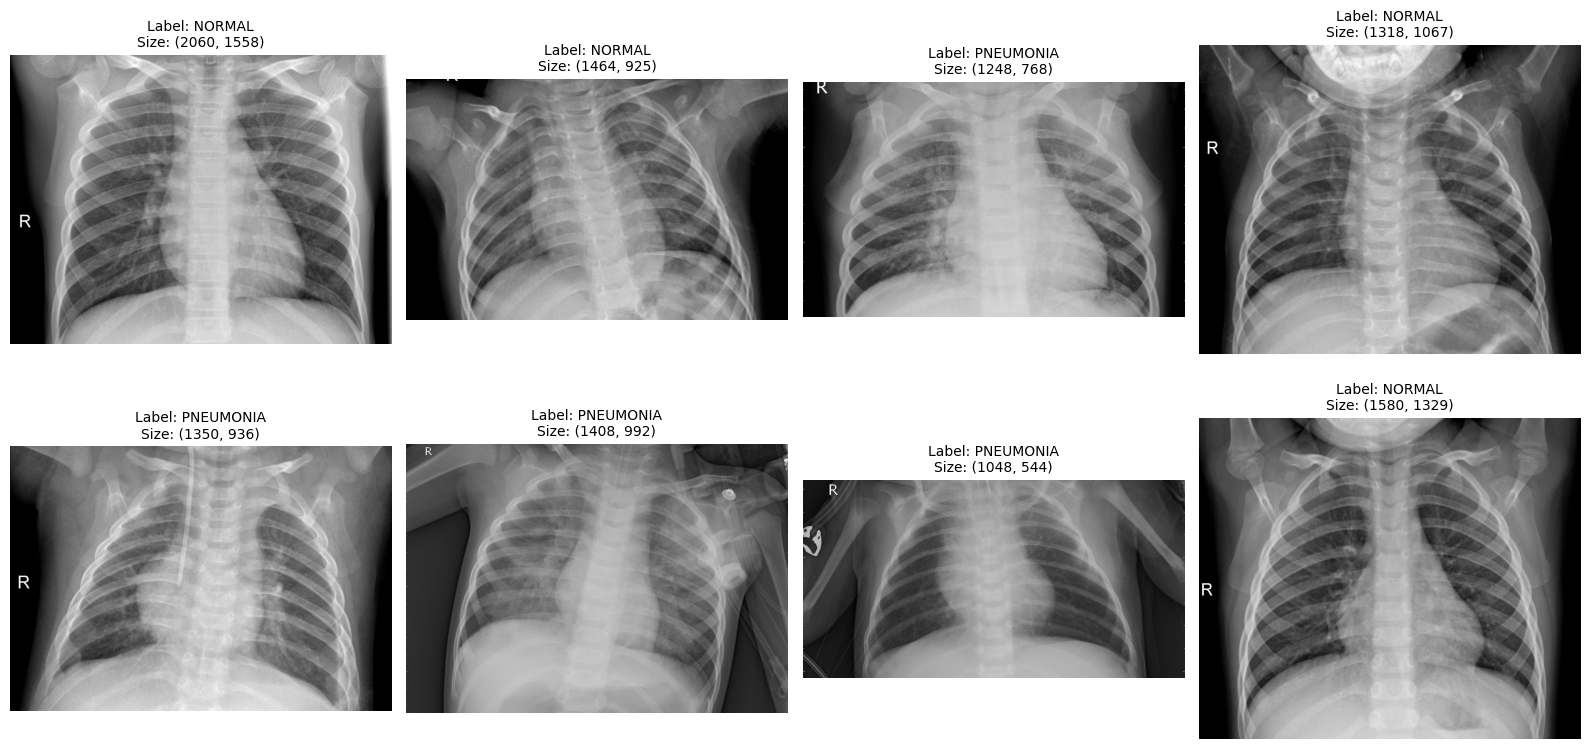

In [21]:
def show_sample_images(df, n_rows=2, n_cols=4):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4))
    axes = axes.ravel()
    normal_samples = df[df['label'] == 'NORMAL'].sample(n_rows * n_cols // 2)['filepath'].tolist()
    pneumonia_samples = df[df['label'] == 'PNEUMONIA'].sample(n_rows * n_cols // 2)['filepath'].tolist()
    samples = normal_samples + pneumonia_samples
    random.shuffle(samples)

    for i, filepath in enumerate(samples):
        img = Image.open(filepath).convert('RGB') # Ensure RGB
        label = df[df['filepath'] == filepath]['label'].values[0]
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}\nSize: {img.size}", fontsize=10)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

print("\nSample Images:")
show_sample_images(all_df)


Image Modes found:
image_mode
L      5573
RGB     283
Name: count, dtype: int64

Image Size distribution summary:
             width       height
count  5856.000000  5856.000000
mean   1327.880806   970.689037
std     363.500922   383.392117
min     384.000000   127.000000
25%    1056.000000   688.000000
50%    1281.000000   888.000000
75%    1560.000000  1187.000000
max    2916.000000  2713.000000


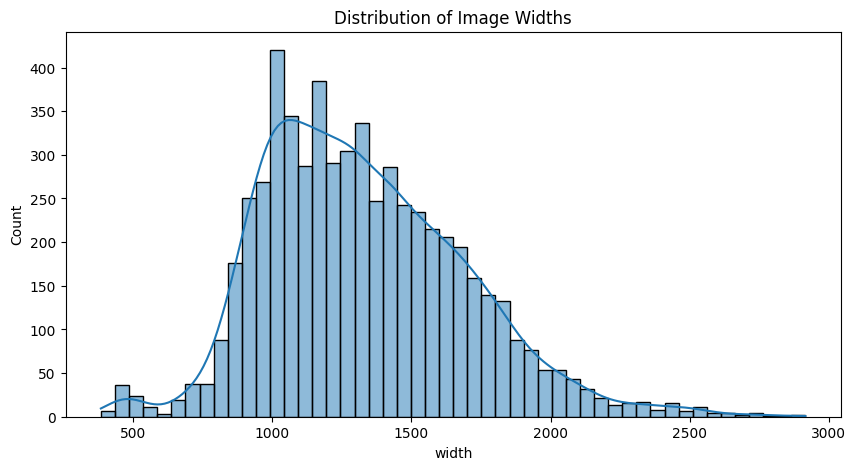

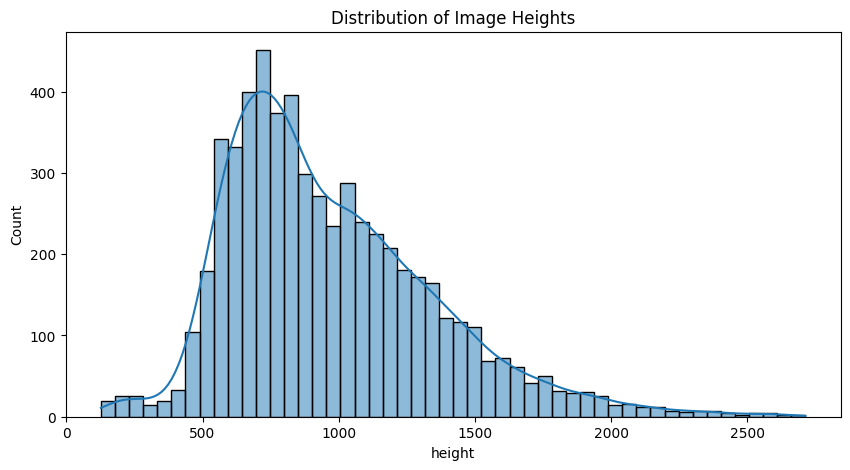

In [22]:
image_sizes = []
image_modes = []
# Sample a subset for speed if needed, e.g., all_df.sample(500)
for filepath in all_df['filepath']:
    try:
        with Image.open(filepath) as img:
            image_sizes.append(img.size)
            image_modes.append(img.mode)
    except Exception as e:
        print(f"Could not read {filepath}: {e}")

all_df['image_size'] = image_sizes
all_df['image_mode'] = image_modes

print("\nImage Modes found:")
print(all_df['image_mode'].value_counts())

print("\nImage Size distribution summary:")
# Need to handle size tuples for description
all_df['width'] = all_df['image_size'].apply(lambda x: x[0])
all_df['height'] = all_df['image_size'].apply(lambda x: x[1])
print(all_df[['width', 'height']].describe())

# Visualize size distribution (optional)
plt.figure(figsize=(10, 5))
sns.histplot(all_df['width'], bins=50, kde=True)
plt.title('Distribution of Image Widths')
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(all_df['height'], bins=50, kde=True)
plt.title('Distribution of Image Heights')
plt.show()